## BERT Spam Detection:

**Assignment 2 - LLM Coding and Report Submission**  
Module: Research Methods In Data Science (7PAM2015-0509-2024)

Author: Harikrishnan Marimuthu

---

In this notebook, we fine-tune a pre-trained BERT model for spam detection on SMS messages. We explore:
- Data cleaning and preprocessing
- Class balancing
- Fine-tuning BERT
- Evaluation metrics
- Example predictions

This notebook satisfies requirements for:
- Text classification using an LLM
- Experimenting with transformer models
- Preparing figures and metrics for a report


In [1]:
# Install necessary libraries
!pip install -q transformers scikit-learn spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 45.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import re
import spacy

sns.set(style="whitegrid")

In [3]:
# Mount Google Drive to access dataset

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

# We use the SMS Spam Collection dataset stored in Google Drive.

In [4]:
# Load the CSV file
csv_path = "/content/drive/My Drive/spam 2.csv"
df = pd.read_csv(csv_path, encoding='latin-1')

# Rename columns
df = df.rename(columns={"v1":"label", "v2":"text"})
df = df[["label", "text"]]

# Drop missing values
df = df.dropna()

# Encode labels as numeric values
df["label"] = df["label"].map({"ham": 0, "spam": 1})

# Preview data
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory Data Analysis

Visualize class distribution.


/tmp/ipython-input-5-2059253688.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df, palette=["#4CAF50", "#FF5722"])


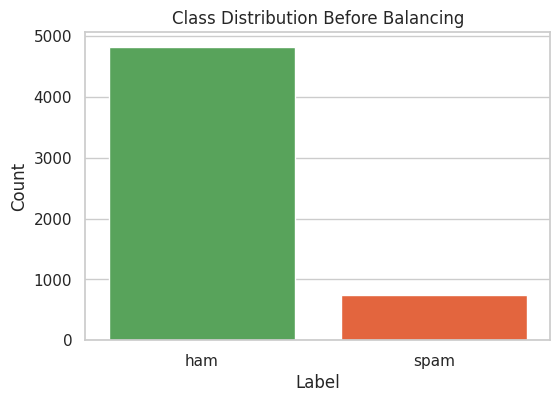

In [5]:
plt.figure(figsize=(6,4))
sns.countplot(x="label", data=df, palette=["#4CAF50", "#FF5722"])
plt.xticks([0,1], ['ham', 'spam'])
plt.title("Class Distribution Before Balancing")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

## Text Cleaning & Lemmatization

We clean text by:
- Lowercasing
- Removing non-alphabetic characters
- Lemmatizing words
- Removing stopwords

This improves model performance by reducing noise.

In [6]:
print("Starting text preprocessing...")

# Load spaCy model
nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser'])
stopwords = spacy.lang.en.stop_words.STOP_WORDS

# Cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.lemma_ not in stopwords]
    return ' '.join(tokens)

df["clean_text"] = df["text"].apply(clean_text)

Starting text preprocessing...


## Distribution of Cleaned Message Lengths


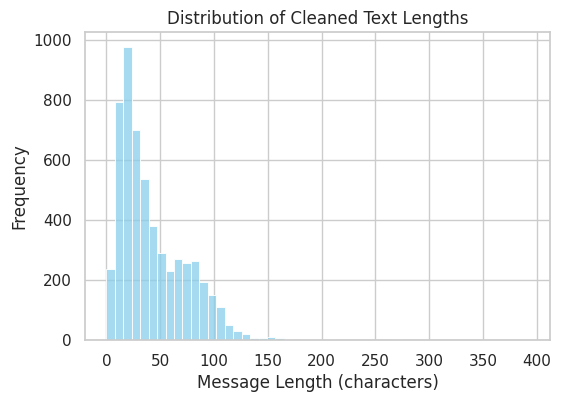

Sample cleaned text:
3245    funny fact teach volcano erupt tsunamis arise ...
944     I send score sophas I secondary application sc...
1044                    know know fancy find pobox lshb p
2484         promise soon ll text I morning let I know ok
812     congratulation ur award cd gift voucher free e...
Name: clean_text, dtype: object


In [7]:
df["text_length"] = df["clean_text"].apply(len)

plt.figure(figsize=(6,4))
sns.histplot(df["text_length"], bins=50, color='skyblue')
plt.title("Distribution of Cleaned Text Lengths")
plt.xlabel("Message Length (characters)")
plt.ylabel("Frequency")
plt.show()

print("Sample cleaned text:")
print(df["clean_text"].sample(5, random_state=42))

## Clip Long Texts

BERT has a max input length of 512 tokens. We truncate messages longer than 512 characters.
*italicized text*

In [8]:
df["clean_text"] = df["clean_text"].apply(lambda x: x[:512])

## Train-Test Split

We split data into training and validation sets.

In [9]:
X_train_orig, X_val_orig, y_train_orig, y_val_orig = train_test_split(
    df["clean_text"],
    df["label"],
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

## Class Balancing

Oversample spam messages to balance the training set.


In [10]:
train_df = pd.DataFrame({
    "text": X_train_orig,
    "label": y_train_orig
})

ham = train_df[train_df["label"] == 0]
spam = train_df[train_df["label"] == 1]

# Oversample spam
spam_oversampled = spam.sample(len(ham), replace=True, random_state=42)

train_balanced = pd.concat([ham, spam_oversampled]).sample(frac=1, random_state=42)

X_train = train_balanced["text"].values
y_train = train_balanced["label"].values
X_val = X_val_orig.values
y_val = y_val_orig.values

## Plot Class Distribution (Balanced Training Set)


/tmp/ipython-input-11-546658691.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_balanced["label"], palette=["#4CAF50", "#FF5722"])


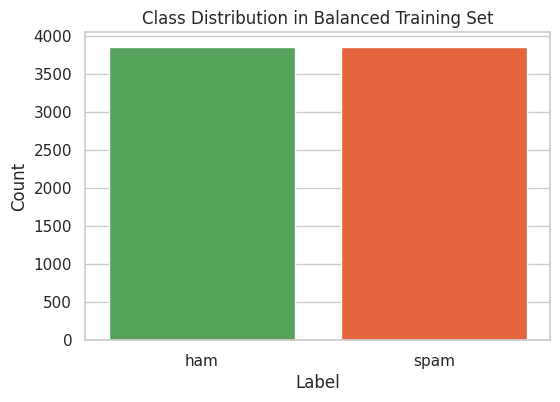

Training set size (balanced):
label
1    3859
0    3859
Name: count, dtype: int64

Validation set size (original, imbalanced):
0    966
1    149
Name: count, dtype: int64


In [11]:
plt.figure(figsize=(6,4))
sns.countplot(x=train_balanced["label"], palette=["#4CAF50", "#FF5722"])
plt.xticks([0,1], ['ham', 'spam'])
plt.title("Class Distribution in Balanced Training Set")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

print("Training set size (balanced):")
print(train_balanced["label"].value_counts())
print("\nValidation set size (original, imbalanced):")
print(pd.Series(y_val).value_counts())

## Compute Class Weights

We use class weights in loss to improve spam recall.


In [12]:
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
print(f"Original computed class weights: {weights}")

# Adjust manually for better spam recall
weights = [1.0, 3.0]
print(f"Adjusted class weights: {weights}")

Original computed class weights: [1. 1.]
Adjusted class weights: [1.0, 3.0]


## Tokenizer and Dataset

We use Hugging Face's BERT tokenizer. Define a custom Dataset for PyTorch.


In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class SpamDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## DataLoaders


In [14]:
MAX_LEN = 64
BATCH_SIZE = 16

train_dataset = SpamDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset = SpamDataset(X_val, y_val, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

## BERT Model Setup


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2
)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 5

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = torch.nn.CrossEntropyLoss(
    weight=torch.tensor(weights, dtype=torch.float).to(device)
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training Function


In [16]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()
    losses = []
    correct_preds = 0

    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_preds += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    acc = correct_preds.double() / len(data_loader.dataset)
    return acc.item(), np.mean(losses)

## Evaluation Function


In [17]:
def eval_model(model, data_loader, device, threshold=0.5):
    model.eval()
    predictions = []
    real_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)
            preds = (probs[:,1] > threshold).long()

            predictions.extend(preds.cpu().numpy())
            real_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(real_labels, predictions)
    print(f"Validation Accuracy: {acc:.4f}")
    print(classification_report(real_labels, predictions, target_names=['ham', 'spam']))

    return acc, predictions, real_labels

## Training Loop


In [18]:
train_accuracies = []
train_losses = []
val_accuracies = []

EPOCHS = 3

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler
    )
    val_acc, _, _ = eval_model(model, val_loader, device, threshold=0.5)

    train_accuracies.append(train_acc)
    train_losses.append(train_loss)
    val_accuracies.append(val_acc)

    print(f"Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f} | Val accuracy: {val_acc:.4f}")


Epoch 1/3


Evaluating: 100%|██████████| 70/70 [00:04<00:00, 17.26it/s]


Validation Accuracy: 0.9821
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       966
        spam       0.93      0.93      0.93       149

    accuracy                           0.98      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Train loss: 0.1086 | Train accuracy: 0.9689 | Val accuracy: 0.9821

Epoch 2/3


Evaluating: 100%|██████████| 70/70 [00:04<00:00, 16.01it/s]


Validation Accuracy: 0.9839
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.98      0.90      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Train loss: 0.0148 | Train accuracy: 0.9968 | Val accuracy: 0.9839

Epoch 3/3


Evaluating: 100%|██████████| 70/70 [00:04<00:00, 17.10it/s]

Validation Accuracy: 0.9865
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       966
        spam       0.99      0.91      0.95       149

    accuracy                           0.99      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115

Train loss: 0.0057 | Train accuracy: 0.9982 | Val accuracy: 0.9865


## Final Evaluation and Confusion Matrix


Evaluating: 100%|██████████| 70/70 [00:04<00:00, 17.03it/s]


Validation Accuracy: 0.9865
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       966
        spam       0.99      0.91      0.95       149

    accuracy                           0.99      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115



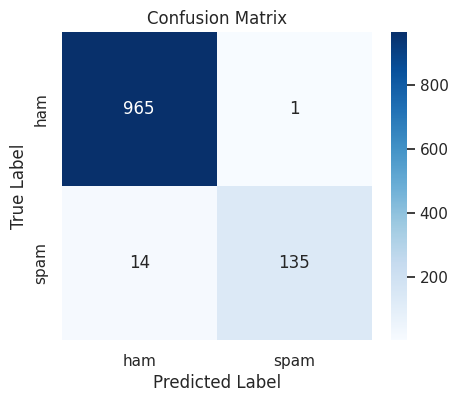

In [19]:
val_acc, preds, truths = eval_model(model, val_loader, device, threshold=0.5)

cm = confusion_matrix(truths, preds)
plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['ham', 'spam'],
    yticklabels=['ham', 'spam']
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Plot Training & Validation Curves


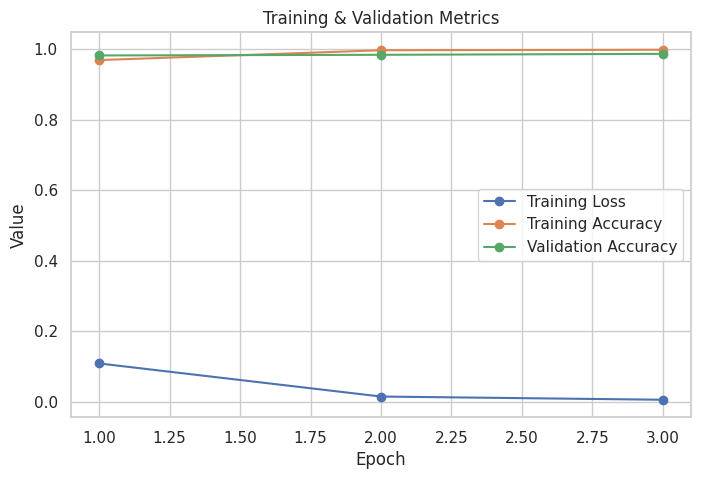

In [20]:
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs_range, train_losses, label='Training Loss', marker='o')
plt.plot(epochs_range, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o')
plt.title("Training & Validation Metrics")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.show()

## Show Random Predictions

In [21]:
random_indices = np.random.choice(len(X_val), size=5, replace=False)

print("\n Showing 5 random validation examples with predictions:\n")

for idx in random_indices:
    text = X_val[idx]

    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_LEN,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = output.logits
        probs = torch.softmax(logits, dim=1)

        if probs[0][1] > 0.5:
            pred_label = 1
        else:
            pred_label = 0

        confidence = probs[0][pred_label].item()

    true_label = y_val[idx]

    label_names = ['ham', 'spam']

    print(f"------------------------------")
    print(f" **Text:** {text}")
    print(f" **True Label:** {label_names[true_label]}")
    print(f" **Predicted Label:** {label_names[pred_label]}")
    print(f" **Confidence:** {confidence:.4f}")


 Showing 5 random validation examples with predictions:

------------------------------
 **Text:** performance award calculate monthnot current month period
 **True Label:** ham
 **Predicted Label:** ham
 **Confidence:** 0.8140
------------------------------
 **Text:** hellodrivbyquit edrunk sorry iff pthis senrddnot dancce drum n basqihave fun nhite x ros xxxxxxx
 **True Label:** ham
 **Predicted Label:** ham
 **Confidence:** 0.9997
------------------------------
 **Text:** I come kerala daysso prepare leave I finalise plan travel visitneed finish urgent work
 **True Label:** ham
 **Predicted Label:** ham
 **Confidence:** 0.9996
------------------------------
 **Text:** x course yrs message messenger lik r send I
 **True Label:** ham
 **Predicted Label:** ham
 **Confidence:** 0.9997
------------------------------
 **Text:** try contact reply offer video phone anytime network min half price line rental camcorder reply
 **True Label:** spam
 **Predicted Label:** spam
 **Confidence:** 0